<a href="https://colab.research.google.com/github/Bagito999/Deep-Learning/blob/main/Deep_RNN_IMDb_ReviewTokoBaju_DeteksiSarkasme.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.0 MB/s eta 0:00:00


#Datasets IMDb

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split
from keras_tuner import Hyperband
import nltk
import os

# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('punkt')

# ==================== GPU SETUP ====================
tf.keras.mixed_precision.set_global_policy('mixed_float16')
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if physical_devices:
    try:
        for gpu in physical_devices:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(f"Error setting memory growth: {e}")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
# ==================== SET SEED & CONFIG ====================
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

BATCH_SIZE = 64
EPOCHS = 10
EPOCHS_TUNER = 4
validation_split = 0.2
MAX_FEATURES = 15000
MAX_LENGTH = 200

# ==================== PREPROCESSING ====================
def preprocess_text_data(texts, labels, max_features, max_length):
    tokenizer = Tokenizer(num_words=max_features)
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)
    X = pad_sequences(sequences, maxlen=max_length)
    y = np.array(labels)
    return X, y, tokenizer

# ==================== BUILD DEEP RNN MODEL ====================
def build_deep_rnn_model(hp, max_features, max_length):
    from tensorflow.keras import regularizers

    model = Sequential()
    model.add(Embedding(
        input_dim=max_features,
        output_dim=hp.Int('embedding_dim', 8, 256, step=8)
    ))

    for i in range(hp.Int('rnn_layers', 1, 3)):
        model.add(SimpleRNN(
            units=hp.Int(f'rnn_units_{i}', 16, 128, step=16),
            return_sequences=(i != hp.Int('rnn_layers', 1, 3) - 1),
            kernel_regularizer=regularizers.l2(0.001)
        ))
        model.add(tf.keras.layers.LayerNormalization())
        model.add(Dropout(hp.Float(f'dropout_{i}', 0.3, 0.7, step=0.1)))

    model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(tf.keras.layers.LayerNormalization())
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            hp.Float('learning_rate', 1e-5, 1e-2, sampling='log')),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

In [4]:
# ==================== EVALUASI & VISUALISASI ====================
def evaluate_and_visualize(model, X_train, y_train, X_test, y_test, dataset_name, results_comparison):
    history = model.fit(
        X_train, y_train,
        validation_split=validation_split,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(X_test, y_test)
    )

    y_prob = model.predict(X_test).flatten()
    y_pred = (y_prob >= 0.5).astype(int)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    fpr, tpr, _ = roc_curve(y_test, y_prob)

    print(f"\nFinal Evaluation on {dataset_name} Test Set:")
    print(f"Accuracy : {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"F1 Score : {f1:.4f}")
    print(f"AUC      : {auc:.4f}")

    # Plot Accuracy & Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy vs Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss vs Epochs')
    plt.legend()
    plt.show()

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{dataset_name} Confusion Matrix')
    plt.show()

    # ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.title(f'{dataset_name} ROC Curve')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.legend()
    plt.grid()
    plt.show()

    # Save to global results
    imdb_results_comparison[dataset_name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "AUC": auc
    }

    return model

  # ==================== PERSIAPAN DATASET ====================
def process_IMDB_dataset():
    from tensorflow.keras.datasets import imdb

    # Load the IMDb dataset
    (X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=MAX_FEATURES)

    # Pad the sequences to the same length
    X_train = pad_sequences(X_train, maxlen=MAX_LENGTH)
    X_test = pad_sequences(X_test, maxlen=MAX_LENGTH)

    return X_train, y_train, X_test, y_test

Trial 10 Complete [00h 00m 55s]
val_accuracy: 0.7522000074386597

Best val_accuracy So Far: 0.8550000190734863
Total elapsed time: 00h 07m 35s

Best Hyperparameters:
embedding_dim: 240
rnn_layers: 1
rnn_units_0: 64
dropout_0: 0.6000000000000001
learning_rate: 0.0004486365513689382
rnn_units_1: 128
dropout_1: 0.3
tuner/epochs: 4
tuner/initial_epoch: 2
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0003
rnn_units_2: 128
dropout_2: 0.6000000000000001
Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - accuracy: 0.5001 - loss: 0.9454 - val_accuracy: 0.5768 - val_loss: 0.8214
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 16s 33ms/step - accuracy: 0.6197 - loss: 0.7828 - val_accuracy: 0.7766 - val_loss: 0.6038
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.8407 - loss: 0.4999 - val_accuracy: 0.7940 - val_loss: 0.6655
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 23s 32ms/step - accuracy: 0.9170 - loss: 0.3266 - val_accuracy: 0.8088 - val_loss: 0.8068
Epoch 5/10
391/391 ━━━━━━━━

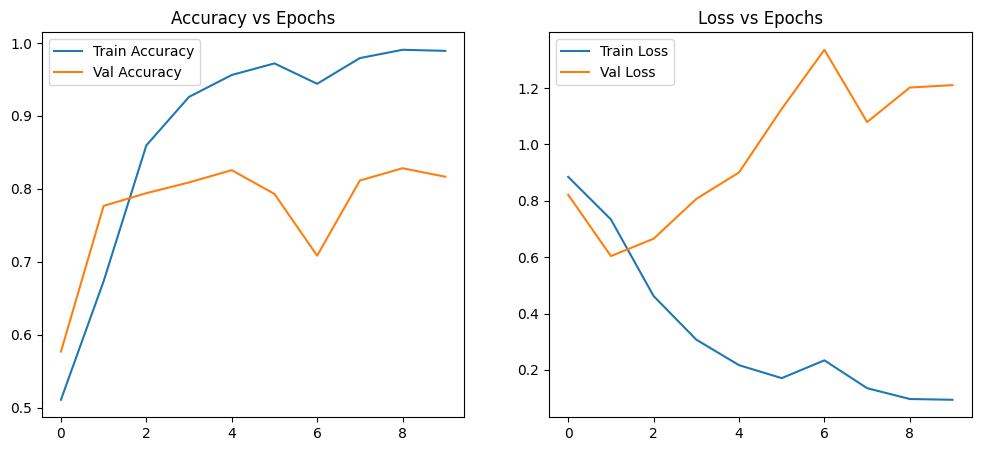

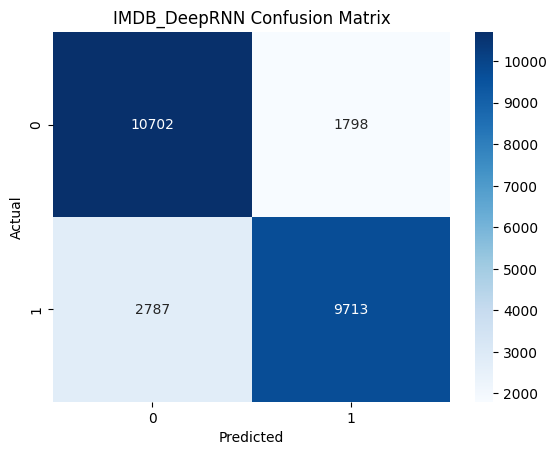

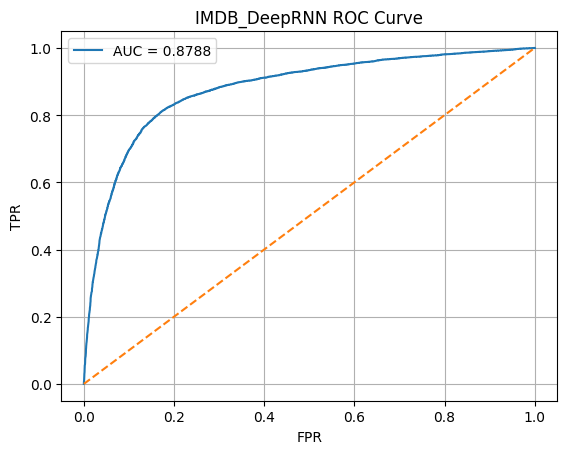


=== RESULTS COMPARISON ===

Dataset: IMDB_DeepRNN
Accuracy: 0.8166
Precision: 0.8438
Recall: 0.7770
F1 Score: 0.8090
AUC: 0.8788


In [5]:
# ==================== EKSEKUSI ====================
def run_experiment(dataset_name, prepare_data_fn, max_features, max_length, results_comparison):
    X_train, y_train, X_test, y_test = prepare_data_fn()

    tuner = Hyperband(
        lambda hp: build_deep_rnn_model(hp, max_features, max_length),
        objective='val_accuracy',
        max_epochs=EPOCHS_TUNER,
        factor=3,
        directory=None,  # Prevent saving tuner results to disk
        project_name=dataset_name
    )

    tuner.search(X_train, y_train,
                 epochs=EPOCHS_TUNER,
                 batch_size=BATCH_SIZE,
                 validation_split=validation_split)

    best_hps = tuner.get_best_hyperparameters(1)[0]
    print("\nBest Hyperparameters:")
    for k, v in best_hps.values.items():
        print(f"{k}: {v}")

    model = tuner.hypermodel.build(best_hps)
    model = evaluate_and_visualize(model, X_train, y_train, X_test, y_test, dataset_name, imdb_results_comparison)

    return model

# ==================== RUN ====================
imdb_results_comparison = {}  # Global dictionary untuk semua dataset

model = run_experiment("IMDB_DeepRNN", process_IMDB_dataset, MAX_FEATURES, MAX_LENGTH, imdb_results_comparison)

print("\n=== RESULTS COMPARISON ===")
for dataset, metrics in imdb_results_comparison.items():
    print(f"\nDataset: {dataset}")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")


#Datasets ReviewTokoBaju

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, LayerNormalization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split
from keras_tuner import Hyperband
import nltk

# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('punkt')

# ==================== GPU SETUP ====================
tf.keras.mixed_precision.set_global_policy('mixed_float16')
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if physical_devices:
    try:
        for gpu in physical_devices:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(f"Error setting memory growth: {e}")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [7]:
# ==================== SET SEED & CONFIG ====================
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

BATCH_SIZE = 64
EPOCHS = 10
EPOCHS_TUNER = 4
validation_split = 0.2
MAX_FEATURES = 15000
MAX_LENGTH = 200

# ==================== GLOBAL RESULTS STORAGE ====================
tokobaju_results_comparison = {}

# ==================== PREPROCESSING ====================
def preprocess_text_data(texts, labels, max_features, max_length):
    tokenizer = Tokenizer(num_words=max_features)
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)
    X = pad_sequences(sequences, maxlen=max_length)
    y = np.array(labels)
    return X, y, tokenizer

# ==================== BUILD DEEP RNN MODEL ====================
def build_deep_rnn_model_hyperband(hp, max_features, max_length):
    from tensorflow.keras import regularizers

    model = Sequential()
    model.add(Embedding(
        input_dim=max_features,
        output_dim=hp.Int('embedding_dim', 8, 256, step=8)
    ))

    # Layer pertama
    units1 = hp.Int('BiRNN_units_1', 32, 128, step=16)
    model.add(Bidirectional(LSTM(units=units1, return_sequences=True, kernel_regularizer=regularizers.l2(0.001))))
    model.add(LayerNormalization())
    model.add(Dropout(hp.Float('dropout_1', 0.3, 0.7, step=0.1)))

    # Layer kedua (Deep RNN)
    units2 = hp.Int('BiRNN_units_2', 32, 128, step=16)
    model.add(Bidirectional(LSTM(units=units2, kernel_regularizer=regularizers.l2(0.001))))
    model.add(LayerNormalization())
    model.add(Dropout(hp.Float('dropout_2', 0.3, 0.7, step=0.1)))

    # Dense output
    model.add(Dense(units2 * 2, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(LayerNormalization())
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            hp.Float('learning_rate', 1e-5, 1e-2, sampling='log')
        ),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

In [8]:
# ==================== EVALUASI & VISUALISASI ====================
def evaluate_and_visualize(model, X_train, y_train, X_test, y_test, dataset_name, model_name):
    history = model.fit(
        X_train, y_train,
        validation_split=validation_split,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(X_test, y_test)
    )

    y_prob = model.predict(X_test).flatten()
    y_pred = (y_prob >= 0.5).astype(int)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    fpr, tpr, _ = roc_curve(y_test, y_prob)

    print(f"\nFinal Evaluation on {dataset_name} ({model_name}) Test Set:")
    print(f"Accuracy : {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"F1 Score : {f1:.4f}")
    print(f"AUC      : {auc:.4f}")

    # Save results into global comparison
    tokobaju_results_comparison[f"{dataset_name} - {model_name}"] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "AUC": auc
    }

    # Visualization
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy vs Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss vs Epochs')
    plt.legend()
    plt.show()

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{dataset_name} ({model_name}) Confusion Matrix')
    plt.show()

    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.title(f'{dataset_name} ({model_name}) ROC Curve')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.legend()
    plt.grid()
    plt.show()

    return history.history

# ==================== PERSIAPAN DATASET ====================
def process_ReviewTokoBaju_dataset():
    file_path = "/content/drive/MyDrive/Deep Learning/ReviewTokoBaju.csv"
    df = pd.read_csv(file_path)

    df = df.drop_duplicates()
    df = df[['Review Text', 'Recommended IND']].dropna()
    df['label'] = df['Recommended IND'].astype(int)

    texts = df['Review Text'].astype(str).tolist()
    labels = df['label'].tolist()

    X, y, tokenizer = preprocess_text_data(texts, labels, MAX_FEATURES, MAX_LENGTH)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

    return X_train, y_train, X_test, y_test

Trial 10 Complete [00h 01m 09s]
val_accuracy: 0.807341992855072

Best val_accuracy So Far: 0.8724813461303711
Total elapsed time: 00h 07m 16s

Best Hyperparameters:
embedding_dim: 248
BiRNN_units_1: 96
dropout_1: 0.3
BiRNN_units_2: 96
dropout_2: 0.3
learning_rate: 0.0001954546396999408
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Epoch 1/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 22s 55ms/step - accuracy: 0.8086 - loss: 1.6000 - val_accuracy: 0.8421 - val_loss: 1.0721
Epoch 2/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 21s 58ms/step - accuracy: 0.8884 - loss: 0.9385 - val_accuracy: 0.8693 - val_loss: 0.8229
Epoch 3/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 19s 53ms/step - accuracy: 0.9178 - loss: 0.6987 - val_accuracy: 0.8715 - val_loss: 0.7543
Epoch 4/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 20s 53ms/step - accuracy: 0.9391 - loss: 0.5585 - val_accuracy: 0.8702 - val_loss: 0.7127
Epoch 5/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 20s 53ms/step - accuracy: 0.9493 - loss: 0.4731 - val_accuracy: 0.8801 - val_loss:

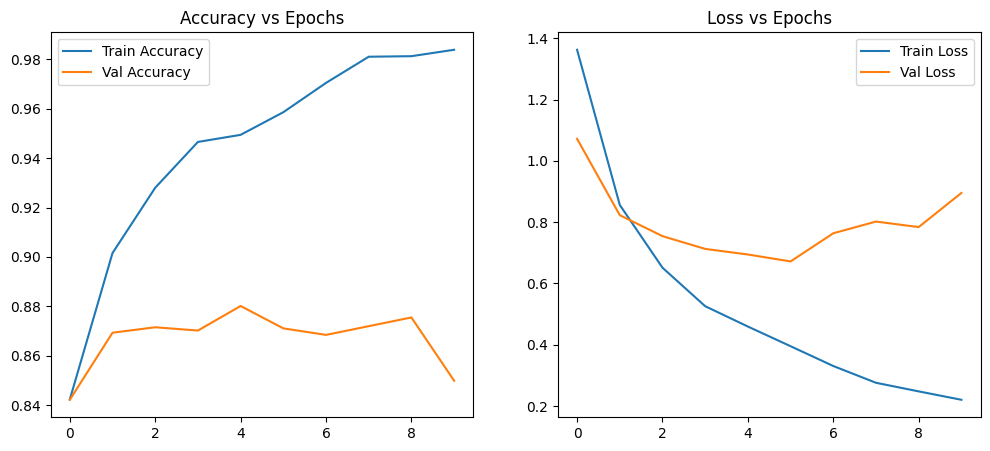

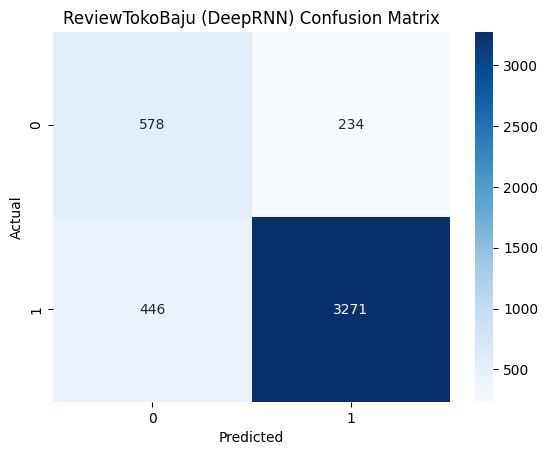

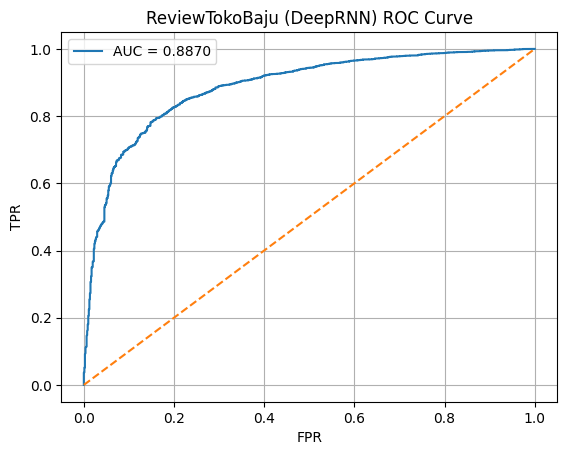


==== ALL RESULTS COMPARISON ====
ReviewTokoBaju - DeepRNN : {'Accuracy': 0.8498564804592625, 'Precision': 0.9332382310984308, 'Recall': 0.8800107613666935, 'F1 Score': 0.9058432567155913, 'AUC': 0.8869923968028669}


In [9]:
# ==================== EKSEKUSI ====================
def run_experiment(dataset_name, prepare_data_fn, max_features, max_length):
    X_train, y_train, X_test, y_test = prepare_data_fn()

    tuner = Hyperband(
        lambda hp: build_deep_rnn_model_hyperband(hp, max_features, max_length),
        objective='val_accuracy',
        max_epochs=EPOCHS_TUNER,
        factor=3,
        directory=f'tuner_{dataset_name}_deep_rnn',
        project_name=f'{dataset_name}_deep_rnn'
    )

    tuner.search(X_train, y_train,
                 epochs=EPOCHS_TUNER,
                 batch_size=BATCH_SIZE,
                 validation_split=validation_split)

    best_hps = tuner.get_best_hyperparameters(1)[0]
    print("\nBest Hyperparameters:")
    for k, v in best_hps.values.items():
        print(f"{k}: {v}")

    model = tuner.hypermodel.build(best_hps)
    history = evaluate_and_visualize(model, X_train, y_train, X_test, y_test, dataset_name, model_name="DeepRNN")

    return model, history

# ==================== RUN ====================
model, history = run_experiment("ReviewTokoBaju", process_ReviewTokoBaju_dataset, MAX_FEATURES, MAX_LENGTH)

# Show all results
print("\n==== ALL RESULTS COMPARISON ====")
for key, value in tokobaju_results_comparison.items():
    print(f"{key} : {value}")

#Datasets DeteksiSarkasme

In [11]:
# ===== Import Libraries =====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import re
import os
import nltk
import tensorflow as tf
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, LayerNormalization
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
from keras_tuner import Hyperband
from tensorflow.keras import regularizers

# ===== Download NLTK data =====
nltk.download('stopwords')
nltk.download('punkt')

# ===== TensorFlow GPU Configuration =====
tf.keras.mixed_precision.set_global_policy('mixed_float16')

physical_devices = tf.config.experimental.list_physical_devices('GPU')
if physical_devices:
    try:
        for gpu in physical_devices:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(f"Error setting memory growth: {e}")

print("GPU Available:", tf.config.list_physical_devices('GPU'))

GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [12]:
# ===== Seed Initialization =====
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# ===== Global Variables =====
BATCH_SIZE = 64
EPOCHS = 5
EPOCHS_TUNER = 4
validation_split = 0.2

# ===== Helper Functions =====

def preprocess_text_data(texts, labels, max_features, max_length):
    tokenizer = Tokenizer(num_words=max_features)
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)
    X = pad_sequences(sequences, maxlen=max_length)
    y = np.array(labels)
    return X, y, tokenizer

def build_deep_rnn_model(hp, max_features, max_length):
    model = Sequential()
    model.add(Embedding(
        input_dim=max_features,
        output_dim=hp.Int('embedding_dim', min_value=8, max_value=256, step=8)
    ))

    # Deep Bidirectional LSTM
    for i in range(hp.Int('num_layers', 2, 4)):  # antara 2 hingga 4 layer
        return_sequences = True if i < hp.get('num_layers') - 1 else False
        model.add(Bidirectional(LSTM(
            units=hp.Int(f'lstm_units_{i}', min_value=32, max_value=128, step=32),
            activation='tanh',
            recurrent_activation='sigmoid',
            return_sequences=return_sequences,
            dropout=hp.Float('dropout_lstm', 0.3, 0.6, step=0.1),
            recurrent_dropout=0.0,
            kernel_regularizer=regularizers.l2(0.001)
        )))

    model.add(LayerNormalization())
    model.add(Dense(hp.Int('dense_units', 64, 256, step=64), activation="relu"))
    model.add(Dropout(hp.Float('dropout_dense', 0.4, 0.6, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='log')
        ),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

def evaluate_and_visualize(model, X_train, y_train, X_test, y_test, dataset_name):
    history = model.fit(
        X_train, y_train,
        validation_split=validation_split,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(X_test, y_test)
    )

    y_prob = model.predict(X_test).flatten()
    y_pred = (y_prob >= 0.5).astype(int)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    fpr, tpr, _ = roc_curve(y_test, y_prob)

    print(f"\nFinal Evaluation on {dataset_name} Test Set:")
    print(f"Accuracy : {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"F1 Score : {f1:.4f}")
    print(f"AUC      : {auc:.4f}")

    # ===== Visualization =====
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title(f'{dataset_name} - Accuracy vs Epochs')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'{dataset_name} - Loss vs Epochs')

    plt.tight_layout()
    plt.show()

    # Confusion Matrix
    class_labels = ['Not Sarcastic', 'Sarcastic']
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels,
                yticklabels=class_labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{dataset_name} - Confusion Matrix')
    plt.show()

    # ROC Curve
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{dataset_name} - ROC Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc,
        'history': history.history
    }

def run_experiment(dataset_name, prepare_data_fn, max_features, max_length):
    print(f"\n{'='*20} Running {dataset_name} Experiment {'='*20}")

    X_train, y_train, X_test, y_test = prepare_data_fn()

    tuner = Hyperband(
        lambda hp: build_deep_rnn_model(hp, max_features, max_length),
        objective='val_accuracy',
        max_epochs=EPOCHS_TUNER,
        factor=3,
        overwrite=True
    )

    print(f"\nTuning model for {dataset_name}...")
    tuner.search(
        X_train, y_train,
        epochs=EPOCHS_TUNER,
        batch_size=BATCH_SIZE,
        validation_split=validation_split
    )

    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    print("\nBest Hyperparameters:")
    for param, value in best_hps.values.items():
        print(f"{param}: {value}")

    best_model = tuner.hypermodel.build(best_hps)

    results = evaluate_and_visualize(
        best_model, X_train, y_train, X_test, y_test,
        dataset_name
    )

    return best_model, results

In [13]:
# ===== Dataset Specific Processing =====

MAX_FEATURES_DeteksiSarkasme = 10000
MAX_LENGTH_DeteksiSarkasme = 35

def process_DeteksiSarkasme_dataset():
    print("\n=== Processing DeteksiSarkasme Dataset ===")
    deteksisarkasme_file = "/content/drive/MyDrive/Deep Learning/DeteksiSarkasme.json"

    with open(deteksisarkasme_file, 'r') as f:
        data = [json.loads(line) for line in f]

    df = pd.DataFrame(data)
    df = df.drop_duplicates()

    def preprocess_text(text):
        text = text.lower()
        text = re.sub(r'https?://\S+|www\.\S+', '', text)
        text = re.sub(r'<.*?>', '', text)
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text

    df['headline'] = df['headline'].apply(preprocess_text)

    X, y, tokenizer = preprocess_text_data(
        df['headline'].tolist(),
        df['is_sarcastic'].tolist(),
        MAX_FEATURES_DeteksiSarkasme,
        MAX_LENGTH_DeteksiSarkasme
    )

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=SEED, stratify=y
    )

    return X_train, y_train, X_test, y_test

Trial 10 Complete [00h 00m 45s]
val_accuracy: 0.8446420431137085

Best val_accuracy So Far: 0.8460458517074585
Total elapsed time: 00h 04m 59s

Best Hyperparameters:
embedding_dim: 112
num_layers: 2
lstm_units_0: 96
dropout_lstm: 0.5
lstm_units_1: 96
dense_units: 192
dropout_dense: 0.5
learning_rate: 0.0029337507407488236
tuner/epochs: 4
tuner/initial_epoch: 2
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0000
lstm_units_2: 32
Epoch 1/5
334/334 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - accuracy: 0.5882 - loss: 0.9027 - val_accuracy: 0.8441 - val_loss: 0.3917
Epoch 2/5
334/334 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.8645 - loss: 0.3876 - val_accuracy: 0.8448 - val_loss: 0.4622
Epoch 3/5
334/334 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.9286 - loss: 0.2646 - val_accuracy: 0.8328 - val_loss: 0.5578
Epoch 4/5
334/334 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - accuracy: 0.9525 - loss: 0.1864 - val_accuracy: 0.8385 - val_loss: 0.5661
Epoch 5/5
334/334 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step

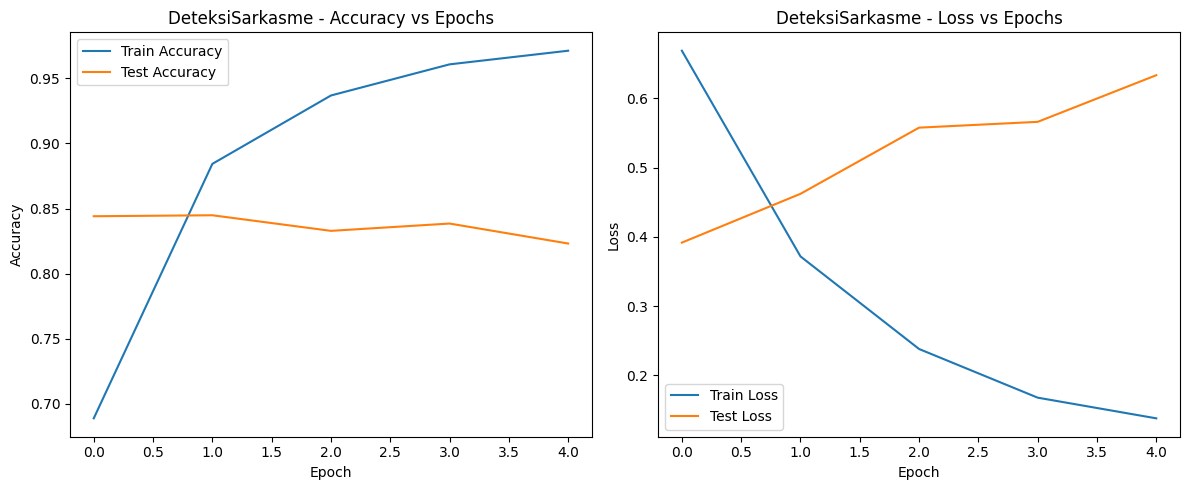

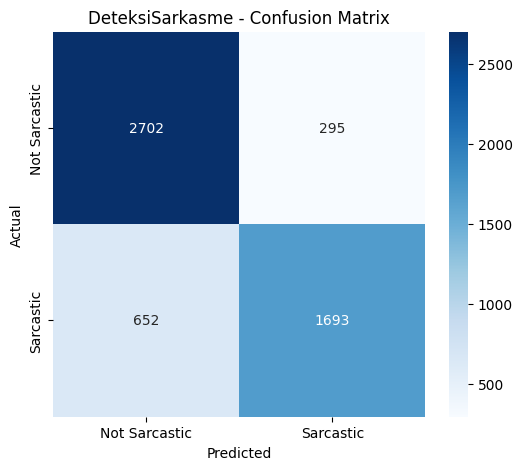

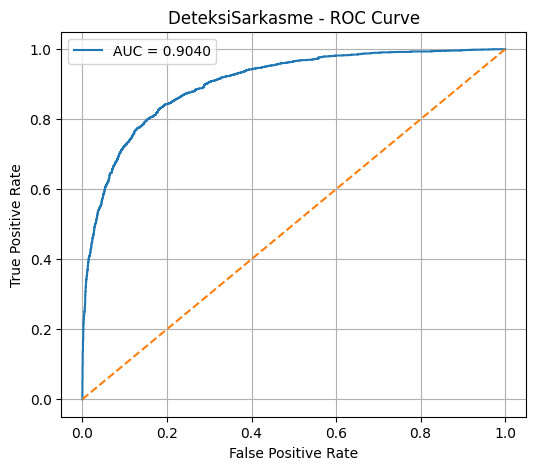


=== Final Comparison Results ===

DeteksiSarkasme
Accuracy: 0.8227
Precision: 0.8516
Recall: 0.7220
F1: 0.7814
Auc: 0.9040


In [14]:
# ===== Main Execution (Auto Multi Dataset) =====

DATASETS = {
    "DeteksiSarkasme": (process_DeteksiSarkasme_dataset, MAX_FEATURES_DeteksiSarkasme, MAX_LENGTH_DeteksiSarkasme)
}

sarkasme_results_comparison = {}

for dataset_name, (prepare_fn, max_features, max_length) in DATASETS.items():
    model, result = run_experiment(dataset_name, prepare_fn, max_features, max_length)
    sarkasme_results_comparison[dataset_name] = {
        'accuracy': result['accuracy'],
        'precision': result['precision'],
        'recall': result['recall'],
        'f1': result['f1'],
        'auc': result['auc']
    }

print("\n=== Final Comparison Results ===")
for dataset, metrics in sarkasme_results_comparison.items():
    print(f"\n{dataset}")
    for metric, value in metrics.items():
        print(f"{metric.capitalize()}: {value:.4f}")

#Hasil Perbandingan

======== Final Results ========



,Dataset,Accuracy,Precision,Recall,F1-Score,AUC-ROC
0,IMDB,0.816600,0.843802,0.777040,0.809046,0.878839
1,ReviewTokoBaju,0.849856,0.933238,0.880011,0.905843,0.886992
2,DeteksiSarkasme,0.822726,0.851610,0.721962,0.781445,0.903975


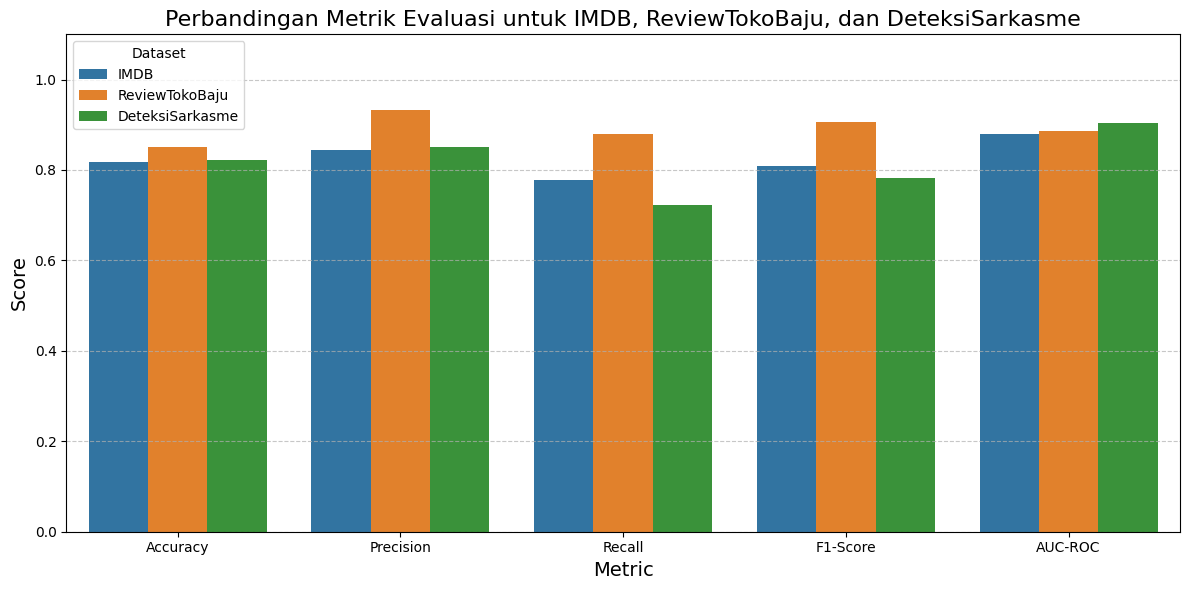

In [38]:
final_results = pd.DataFrame({
    "Dataset": ["IMDB", "ReviewTokoBaju", "DeteksiSarkasme"],
    "Accuracy": [
        imdb_results_comparison["IMDB_DeepRNN"]["Accuracy"],
        tokobaju_results_comparison["ReviewTokoBaju - DeepRNN"]["Accuracy"],
        sarkasme_results_comparison["DeteksiSarkasme"]["accuracy"]
    ],
    "Precision": [
        imdb_results_comparison["IMDB_DeepRNN"]["Precision"],
        tokobaju_results_comparison["ReviewTokoBaju - DeepRNN"]["Precision"],
        sarkasme_results_comparison["DeteksiSarkasme"]["precision"]
    ],
    "Recall": [
        imdb_results_comparison["IMDB_DeepRNN"]["Recall"],
        tokobaju_results_comparison["ReviewTokoBaju - DeepRNN"]["Recall"],
        sarkasme_results_comparison["DeteksiSarkasme"]["recall"]
    ],
    "F1-Score": [
        imdb_results_comparison["IMDB_DeepRNN"]["F1 Score"],
        tokobaju_results_comparison["ReviewTokoBaju - DeepRNN"]["F1 Score"],
        sarkasme_results_comparison["DeteksiSarkasme"]["f1"]
    ],
    "AUC-ROC": [
        imdb_results_comparison["IMDB_DeepRNN"]["AUC"],
        tokobaju_results_comparison["ReviewTokoBaju - DeepRNN"]["AUC"],
        sarkasme_results_comparison["DeteksiSarkasme"]["auc"]
    ]
})

print("======== Final Results ========\n")
display(final_results)

import matplotlib.pyplot as plt
import seaborn as sns

# Mengubah final_results menjadi format long agar mudah dipakai di seaborn
final_results_melted = final_results.melt(id_vars="Dataset", var_name="Metric", value_name="Score")

# Mengatur ukuran figure
plt.figure(figsize=(12, 6))

# Membuat barplot
sns.barplot(
    data=final_results_melted,
    x="Metric",
    y="Score",
    hue="Dataset"
)

# Memberikan title dan label
plt.title("Perbandingan Metrik Evaluasi untuk IMDB, ReviewTokoBaju, dan DeteksiSarkasme", fontsize=16)
plt.xlabel("Metric", fontsize=14)
plt.ylabel("Score", fontsize=14)
plt.ylim(0, 1.1)  # Supaya lebih rapi di atas 1
plt.legend(title="Dataset")
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Menampilkan plot
plt.tight_layout()
plt.show()

